In [5]:
%matplotlib inline

from matplotlib.pyplot import * # plotting library
# math stuff
from math import *
from numpy import *
# scipy for reference
import scipy.cluster
# makes figures larger
matplotlib.rcParams['figure.figsize'] = (10,5)

# Radial Basis Functions, competetive learning and self-organization

In the previous project, we used single perceptron to classify linearly separable data and Multilayer Perceptrons to separate data using hyperplanes.

Radial Basis Functions are a class of symmetric functions where the value is dependent only on the distance from the center, a Radial Basis Function network uses a linear combination of radial basis functions to reconstruct a given function.

Competetive learning is a strategy for unsupervised learning where individual neurons are competing against each other for activation, Radial Basis Functions are used to evaluate which neurons have "won" (details below). 

Self-organization is a behaviour resulting from competitive learning, by extension Self Organizing Maps is an algorithm which projects a n-dimensional input into a (often) 2 dimensional plane. It uses competetive learning along with collaboration within a neighbourhood (defined by a radial basis function that decreases over time) to perform self-organization.

We start with Radial Basis Functions.

## Radial Basis Functions

A Radial Basis Function Network is a 3-layer network (inputs, radial basis layer, output layer). It is a two-step learning algorithm:

1. Find representative centers on the dataset using k-means (unsupervised) or random sampling of the inputs
2. Find weight matrix

Let's generate some data to first test our network. We generate two sets of data defined by the following functions:

$$
\begin{align}
y & = \sin(x) \\
z & = \text{sgn}(\sin(x)) \\
  & = \text{square}(x)
\end{align}
$$

where $\text{sgn}(x)$ is the `sign` function.

We generate these for two sets of data, test and training. The test set covers of $ x \in [0, 2\pi] $ and the training set covers $ x \in [0.05, 2\pi] $. Ideally, if the network is trained properly, we should be able to produce identical results when passing the test dataset through the network.

In [6]:
# define x ranges
x_train = arange(0, 2*pi, 0.1)
x_test = arange(0.05, 2*pi, 0.1)

# find training data
y_train = sin(2*x_train)
z_train = sign(y_train)

# find test data
y_test = sin(2*x_test)
z_test = sign(y_test)

Text(0.5,0.98,'training dataset')

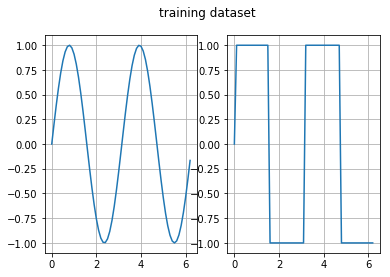

In [7]:
subplot(1, 2, 1)
plot(x_train, y_train)
grid()
subplot(1, 2, 2)
plot(x_train, z_train)
grid()
suptitle('training dataset')

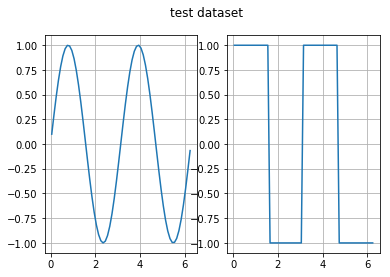

In [5]:
subplot(1, 2, 1)
plot(x_test, y_test)
grid()
subplot(1, 2, 2)
plot(x_test, z_test)
suptitle('test dataset')
grid()

### Radial Basis Function Networks

As stated earlier, a Radial Basis Function Network is a 3-layer neural network. It consits of an input layer which are fully connected to the hidden layers and an output layer with a single output node. 

![Full RBFN Model](rbfn_full.png)

or a more compact form:

![Compact RBFN Model](rbf_compact.png)

Note that there are no weights associated between the input and the hidden layer. Let $ N $ denote the number of input and $ n $ the number of nodes in the hidden layer.

The Radial Basis function that we will use is a gaussian distribution and is defined as:

$$
\phi_{i}(x) = e^{\frac{-(x-\mu_i)^2}{2\sigma_{i}^2}}
$$

Where $ i $ is the index of the hidden layer, $ \sigma_{i} $ is the node-specific variance (we assume this to be constant for all nodes in this project), $ \mu_{i} $ is the center of the distribution.

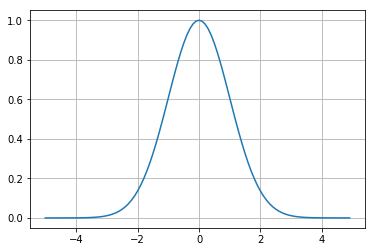

In [6]:
def rbf(x, mu, sig):
    return exp(-power(x - mu, 2) / (2 * power(sig, 2)))

x = arange(-5, 5, 0.1)
y = rbf(x, 0, 1)

plot(x, y)
grid()

The idea is that any function can be approximated as a linear combination of $ \phi_{i} $, and we want to optimize the weights $ w_{i} $. For example if we have a set of equidistant distributions with overlapping ends we can scale and combine them to approximate any function (a universal approximator).

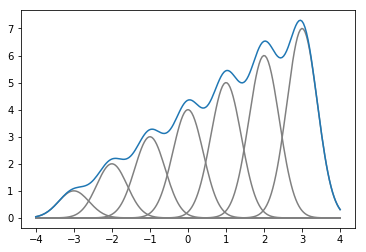

In [7]:
centers = arange(-4, 4, 1)
domain = linspace(-4, 4, 200)
combined = zeros(domain.shape)
for i, c in enumerate(centers):
    rang = i * rbf(domain, c, 0.4)
    combined += rang
    plot(domain, rang, color='gray')
plot(domain, combined)

The output layer then is a linear combination of the weights and the radial bases:

$$
\hat{f} = \sum_{i}^{n} \phi_{i}(x) w_{i}
$$

We can rewrite it in vector notation:

$$
\mathbf{f} = \mathbf{\Phi w}
$$

Since we want to optimize the weights matrix we need to find a solution to this equation system. There are two ways of doing this, least squares (batch) and Delta Rule (sequential).

#### Least squares

The least squares solution is an analytical solution to the RBF problem. It relies on inverting the $ \mathbf{\Phi} $ matrix. However, since it can be singular (and thus no inverse defined because $ \det{\mathbf{\Phi}} = 0 $ we need to use a pseudo inverse defined as $ \mathbf{\Phi}^\text{T}\mathbf{\Phi} $. Thus the solution is:

$$
\mathbf{\Phi}^\text{T}\mathbf{\Phi w} = \mathbf{\Phi}^\text{T}\mathbf{f}
$$

To implement this, let us first define a function that generates the $ \mathbf{\Phi} $ matrix for any given set of inputs.

The $ \mathbf{\Phi} $ matrix can be derived from:

$$
\hat{f}_k = \sum_{i}^{n} \phi_{i}(x_k) w_{i}
$$

which can be expand it into:

$$
\begin{align}
\phi_{1}(x_1) w_1 + \phi_{2}(x_1) w_2 + \cdots + \phi_{n}(x_1) w_n & = f_1 \\
\phi_{1}(x_2) w_1 + \phi_{2}(x_2) w_2 + \cdots + \phi_{n}(x_2) w_n & = f_2 \\
& \vdots \\
\phi_{1}(x_N) w_1 + \phi_{2}(x_N) w_n + \cdots + \phi_{n}(x_N) w_n & = f_N \\
\end{align}
$$

This can be rewritten in the matrix-vector notation:

$$
\mathbf{\Phi w} = \mathbf{f}
$$

by setting:

$$
\mathbf{\Phi} = \begin{bmatrix}
\phi_1(x_1) & \phi_2(x_1) & \cdots & \phi_n(x_1) \\
\phi_1(x_2) & \phi_2(x_2) & \cdots & \phi_n(x_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_1(x_N) & \phi_2(x_N) & \cdots & \phi_n(x_N) \\
\end{bmatrix} \begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n
\end{bmatrix} = \begin{bmatrix}
f_1 \\
f_2 \\
\vdots \\
f_N
\end{bmatrix}
$$

We start by writing a function to generate the $ \mathbf{\Phi} $ matrix. It will have four parameters:

```
inputs : the set of inputs x_i
sig : a constant value specifying the spread of each RBF
kMeans : whether to use kMeans or random sampling to choose centers. The benefit of kMeans is that it guarantees the centers are maximally separated and thus most representative of the datset.
centers : Preselected centers
```

The final parameter is required due to our functional style of writing the network. Later we will rewrite it in a much more compact way.

In [12]:
def find_phi(inputs, sig=1, kMeans=False, centers=None):
    N = max(inputs.shape) # input
    n = 10 # number of hidden nodes
    
    if centers is None: # if no centers are supplied, find our own
        if kMeans:
            mu = scipy.cluster.vq.kmeans(inputs, n + 1)[0]
        else: # select n + 1 random samples (with replacement) from the input the + 1 is for the bias node
            mu = random.choice(inputs, (n + 1, 1))
    else: # allow us to reuse centers
        mu = centers
    
    # initialize phi with zeros
    phi = zeros((N, n + 1))
    
    for i in range(0, n): # fill the phi matrix column-wise
        phi[:,i] = rbf(inputs - mu[i], 0, sig)
    
    # set bias node
    phi[:,i+1] = 1
    
    # return both the phi matrix and the centers (useful for visualisation)
    return phi, mu

The training function will simply take a set of inputs and targets, calculate the phi matrix and use the least squares approximation to calculate the weights.

In [13]:

def train_ls(inputs, targets, sig=1, kMeans=False):
    # find phi matrix
    phi, centers = find_phi(inputs, sig, kMeans)
    
    # calculate weights using least squares
    weights = dot(linalg.pinv(dot(phi.T, phi)), dot(phi.T, targets))

    return weights, centers

The predict function will take the centers, weights and test inputs and return the predictions.

In [15]:
def predict_ls(centers, weights, inputs, sig=1):
    phi, centers = find_phi(inputs, sig, False, centers=centers)
    
    prediction = dot(phi, weights)
    
    return prediction

We can now run these with our test dataset.

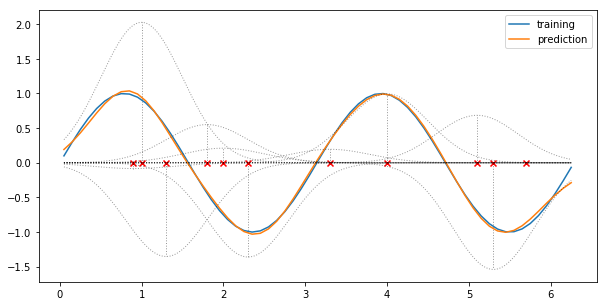

In [17]:
sig = 0.5

weights, centers = train_ls(x_train, y_train, sig=sig) # train our network
prediction = predict_ls(centers, weights, x_test, sig=sig) # predict test data
plot(test_x, test_y)
plot(test_x, prediction)
legend(('training', 'prediction'))
scatter(centers, zeros(centers.shape), marker='x', color='red')

x_range = linspace(min(test_x), max(test_x), 1000)
for i, c in enumerate(centers):
    r = weights[i] * rbf(x_range, c, sig)
    plot(x_range, r, ':', alpha=0.4, color='k', linewidth=1)
    vlines(c, 0, weights[i], alpha=0.4, color='k', linewidth=1, linestyle=':')

We can see the effect of not using kMeans on the centers. They are randomly distributed across the domain, in this particular case it doesn't affect the performance too much as the data is well represented across the domain. However in cases where most of the dynamics is concentrated unevenly, it's better to use a clustering algorithm such as kMeans. We can see the effect of using kMeans on the same dataset.

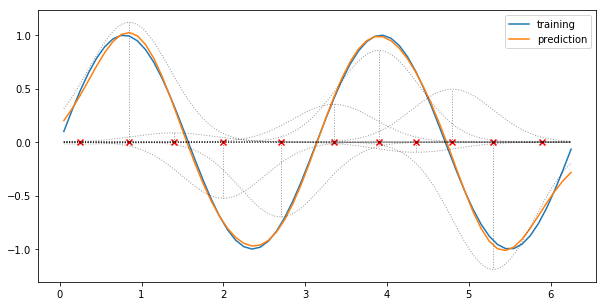

In [19]:
sig = 0.5

weights, centers = train_ls(x_train, y_train, sig=sig, kMeans=True) # train our network
prediction = predict_ls(centers, weights, x_test, sig=sig) # predict test data
plot(test_x, test_y)
plot(test_x, prediction)
legend(('training', 'prediction'))
scatter(centers, zeros(centers.shape), marker='x', color='red')

x_range = linspace(min(test_x), max(test_x), 1000)
for i, c in enumerate(centers):
    r = weights[i] * rbf(x_range, c, sig)
    plot(x_range, r, ':', alpha=0.4, color='k', linewidth=1)
    vlines(c, 0, weights[i], alpha=0.4, color='k', linewidth=1, linestyle=':')

Clearly, the center are well separated and thus have a higher probability of representing the dataset well. Our implementation currently relies on a lot of data that should be automatically handled, for example we need to pass the `sigma` value to both the training and prediction, and we need to keep track of the centers. Instead, let us package these into a class so that we can perform training and prediction easily.

Ideally instead of:

```python
weights, centers = train_ls(x_train, y_train, sig=sig, kMeans=True) # train our network
prediction = predict_ls(centers, weights, x_test, sig=sig) # predict test data
```

We would like to write:

```python
network = RBF(sig=sig, kMeans=True)
weights, centers = network.train(x_train, y_train)
prediction = network.predict(x_test)
```

which is both visually less dense and concise.

In [2]:
class RBF_LS:
    def __init__(self, sig=1, kMeans=False, nHidden=10):
        self.sig = sig
        self.kMeans = kMeans
        self.nHidden = nHidden
        
        # these change after every training
        self.centers = None
        self.weights = None
        
    def rbf(self, x, sig): # from function rbf
        return exp(-power(x, 2) / (2 * power(sig, 2)))
    
    def calculatePhi(self, inputs, centers, sig): # from function find_phi
        N = max(inputs.shape) # input
        n = self.nHidden # number of hidden nodes

        # initialize phi with zeros
        phi = zeros((N, n + 1))

        for i in range(0, n): # fill the phi matrix column-wise
            phi[:,i] = self.rbf(inputs - centers[i], sig)

        # set bias node
        phi[:,i+1] = 1

        # return both the phi matrix and the centers (useful for visualisation)
        return phi
    
    def getCenters(self, inputs, n, kMeans=False):
        if kMeans:
            return scipy.cluster.vq.kmeans(inputs, n + 1)[0]
        else: # select n + 1 random samples (with replacement) from the input the + 1 is for the bias node
            return random.choice(inputs, (n + 1, 1))
    
    def train(self, inputs, targets):
        self.centers = self.getCenters(inputs, self.nHidden, self.kMeans)
        phi = self.calculatePhi(inputs, self.centers, self.sig)

        # calculate weights using least squares
        self.weights = dot(linalg.pinv(dot(phi.T, phi)), dot(phi.T, targets))
        
        error = linalg.norm(self.predict(inputs) - targets)

        return error
    
    def predict(self, inputs):
        phi = self.calculatePhi(inputs, self.centers, self.sig)

        prediction = dot(phi, self.weights)

        return prediction

We can now use our library to test multiple datasets with fixed parameters very easily.

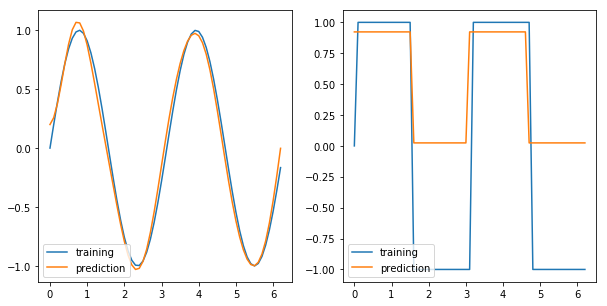

In [41]:
net = RBF_LS(sig=0.5, kMeans=True, nHidden=10)

net.train(x_train, y_train)
prediction_y = net.predict(x_test)

net.sig=0.2
net.train(x_train, z_train)
prediction_z = net.predict(z_test)

subplot(1, 2, 1)
plot(x_train, y_train)
plot(x_train, prediction_y)
legend(('training', 'prediction'))
subplot(1, 2, 2)
plot(x_train, z_train)
plot(x_train, prediction_z)
legend(('training', 'prediction'))

In [11]:
goals = [0.1, 0.01, 0.001]

network = RBF_LS(0.5, kMeans=True)

print("sin(2x) dataset")
print("goal\tnHidden")
for goal in goals:
    error = 1.0
    network.nHidden = 1 # start with 1 hidden layer
    
    while error > goal:
        error = network.train(x_train, y_train)
        network.nHidden = network.nHidden + 1
    
    print("%s\t%s" % (goal, network.nHidden))

print("")

print("square(2x) dataset")
print("goal\tnHidden")

network.sig = 0.05
for goal in goals:
    error = 1.0
    network.nHidden = 1 # start with 1 hidden layer
    
    while error > goal and network.nHidden < x_train.shape[0]:
        network.train(x_train, z_train)
        network.nHidden = network.nHidden + 1
    
    print("%s\t%s" % (goal, network.nHidden))

sin(2x) dataset
goal	nHidden
0.1	17
0.01	21
0.001	57

square(2x) dataset
goal	nHidden
0.1	63
0.01	63
0.001	63
